In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate

# Runge Kutta method

Let be the o.d.e
$$\frac{d y(t)}{dt} = f(t, y(t))$$

## RK45
The step $y_{i+1}$ is given by

$$\begin{cases}t_{i+1} &= t_i + h \\
y_{i+1} &= y_i + \frac{1}{6}(k_1+2k_2+2k_3+k_4)
\end{cases}$$
where the weights are given by
    
$$\begin{cases}k_1 &= h f(t_i, y_i) \\
k_2 &= h f(t_i + \frac{h}{2}, y_i + \frac{1}{2}k_1) \\
k_3 &= h f(t_i+\frac{h}{2}, y_i + \frac{1}{2}k_2) \\
k_4 &= h f(t_i + h, y_i + \frac{1}{2}k_3) 
\end{cases}$$


## RKF45
### Scheme
The step $y_{i+1}$ is calculated using six factors

$$\begin{cases}k_1 &= h f(t, y_i) \\
k_2 &= h f(t + \frac{1}{4}h, y_i + \frac{1}{4}k_1) \\
k_3 &= h f(t+\frac{3}{8}h, y_i + \frac{3}{32}k_1 + \frac{9}{32} k_2) \\
k_4 &= h f(t + \frac{12}{13}h, y_i + \frac{1932}{2197}k_1 - \frac{7200}{2197}k_2 + \frac{7296}{2196}k_3) \\
k_5 &= h f(t+h, y_i + \frac{439}{216}k_1 - 8k_2 \frac{3680}{513}k_3 - \frac{845}{4104}k_4) \\
k_6 &= h f(t+\frac{1}{2}h, y_i - \frac{8}{27}k_1 + 2k_2 - \frac{3544}{2565}k_3 + \frac{1859}{4104}k_4 - \frac{11}{40}k_5)\end{cases}$$

Thus,
$$y_{i+1} = y_i + \frac{25}{216}k_1 + \frac{1408}{2565}k_3 + \frac{2197}{4104}k_4 - \frac{1}{5}k_5 $$

### Adaptative time-step

There exists another estimate of the next step $y_{i+1}$, that we will denote $z_{i+1}$ :
$$z_{i+1} = y_i + \frac{16}{135}k_1 + \frac{6656}{12825}k_3 + \frac{28561}{56430}k_4 - \frac{9}{50}k_5 + \frac{2}{55}k_6$$

Therefore, we can define an error $\epsilon$ as
$$\epsilon = |y_{i} - z_{i}|$$
which allows us to calculate a new time step $h_{i+1}$ such that
$$h_{i+1} = h_{i} S \left( \frac{\tau}{\epsilon}\right)^{1/5}$$

where $h_i$ is the previous time-step, $S$ is a security factor (usually $S=0.9$), $\tau$ is the tolerance (usually $\tau \sim 10^{-6}$). Thus, if the error is higher than the tolerance, the time-step is reduced, otherwise it is increased.

In [45]:
def euler(func, t0, y0, h) :
    return t0+h, y0+ h*func(t0, y0)

def rk45(func, t0, y0, h) :
    try :
        k1 = func(t0, y0)
        k2 = func(t0 + 0.5*h, y0 + 0.5*h*k1)
        k3 = func(t0 + 0.5*h, y0 + 0.5*h*k2)
        k4 = func(t0 + h, y0 + h*k3)
        return t0+h, y0 + h*(k1+2*k2+2*k3+k4) / 6.
        
    except : return None

def calc_new_timestep(error, tolerance, secure=0.9, cst_tstep=False) :
    if cst_tstep :
        s = secure
    else :
        if error == 0. :
            #print('No error')
            s = secure
        elif error > tolerance :
            s = secure*(tolerance / error)**(0.2)
            #ratio = (tolerance / (2.*error))**0.5
            #s = secure*min(2., max(0.3, ratio))
        else :
            s = secure*(tolerance / error)**(0.25)
            #ratio = (tolerance / (2.*error))**0.5
            #s = secure*min(2., max(0.3, ratio))
    return s
    
    
def rkf45(func, t0, y0, h, tol) :
    if 1 :
    #try :
        k1 = h*func(t0, y0)
        k2 = h*func(t0 + 0.25*h, y0 + 0.25*k1)
        k3 = h*func(t0 + (3./8.)*h, y0 + (3./32.)*k1 + (9./32.)*k2)
        k4 = h*func(t0 + (12./13.)*h, y0 + (1932./2197.)*k1 - (7200./2197.)*k2 + (7296./2197.)*k3)
        k5 = h*func(t0 + h, y0 + (439./216.)*k1 - 8.*k2 + (3680./513.)*k3 - (845./4104.)*k4)
        k6 = h*func(t0 + 0.5*h, y0 - (8./27.)*k1 + 2*k2 - (3544./2565)*k3 + (1859./4104.)*k4 - (11./40.)*k5)
        
        new_y = y0 + (25./216.)*k1 + (1408./2565.)*k3 + (2197./4104.)*k4 - (1./5.)*k5
        new_z = y0 + (16./135.)*k1 + (6656./12825.)*k3 + (28561./56430.)*k4 - (9./50.)*k5 + (2./55.)*k6
        
        
        error = abs(new_z - new_y)
        #print(error)
        s = calc_new_timestep(error, tolerance=tol, cst_tstep=False)
        return t0+h, new_y, s
    #except :
    else :
        return None

def integrate(func, y0, tspan, y_bounds=None, timestep=1e-1, method = 'rk45', tol = 1e-2, t0=0, min_timestep=1e-6) :
    nsteps = int((tspan[1] - tspan[0])/timestep)
    
    if method == 'euler' :
        sol = [y0]
        time = [t0]
        for n in range(1, nsteps+1) :
            try :
                if y_bounds == None :
                    t, s = euler(func, time[n-1], sol[n-1], timestep)
                    time += [t]
                    sol += [s]
                else :
                    if sol[n-1] >= min(y_bounds) and sol[n-1] <= max(y_bounds) :
                        t, s = euler(func, time[n-1], sol[n-1], timestep)
                        time += [t]
                        sol += [s]
                    else :
                        print('Stop integration, bounds reached.')
                        break ;
            except :
                break ;
    if method == 'rk45' :
        sol = [y0]
        time = [t0]
        for n in range(1, nsteps+1) :
            try :
                if y_bounds == None :
                    t, s = rk45(func, time[n-1], sol[n-1], timestep)
                    time += [t]
                    sol += [s]
                else :
                    if sol[n-1] >= min(y_bounds) and sol[n-1] <= max(y_bounds) :
                        t, s = euler(func, time[n-1], sol[n-1], timestep)
                        time += [t]
                        sol += [s]
                    else :
                        print('Stop integration, bounds reached.')
                        break ;
            except :
                break ;
    elif method == 'rkf45' :
        t, s = tspan[0], y0
        sol = [y0]
        time = [t]
        n = 1
        while t < tspan[1] :
            if sol[n-1] == None :
                break ;
            #try :
            if 1:
                t, s, o = rkf45(func, time[n-1], sol[n-1], timestep, tol)
                time += [t]
                sol += [s]
                #timestep = np.max([min_timestep, timestep*o])
                timestep *= o
                n += 1
                #print(n, t, timestep)
            #except :
            else :
                break ;
    return time, sol


In [19]:
def f(t, y, min_y=1e-4) :
    if y > min_y :
        return np.sqrt(1./2.-y) - np.sqrt(1./y)
    else : return None
    #return -0.5*y
    
def fx(t, y, r=100., a=.3) :
    return r*y*(a-y)

def fx2(t, y, r=200.) :
    return r*y

def real_solution(t) :
    return np.exp(-0.5*t)

In [20]:
h = 0.01
y0 = 1e-5
nsteps = 100

tpsan = [0., 1.]
print('Euler')
t1, sol1 = integrate(fx, y0, tpsan, timestep=h, t0=0., method = 'euler')
print(len(t1))
print('RK45')
t2, sol2 = integrate(fx, y0, tpsan, timestep=h, t0=0., method = 'rk45')
print(len(t2))
print('RKF45')
t3, sol3 = integrate(fx, y0, tpsan, timestep=h, t0=0., tol = 1e-7, method='rkf45')
#print(len(t3))

Euler
101
RK45
101
RKF45


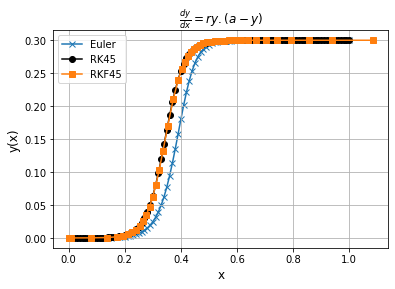

In [21]:
real_t = np.linspace(tpsan[0], tpsan[1])

real_sol = np.tan(real_t)
#plt.plot(real_t, real_sol, label = 'real', zorder=10, color='k')
plt.plot(t1, sol1, label = 'Euler', marker='x', zorder=1)
plt.plot(t2, sol2, label = 'RK45', marker='o', zorder=2, color = 'k')
plt.plot(t3, sol3, label = 'RKF45', marker='s', alpha=1.)

#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.grid()
plt.title(r'$\frac{dy}{dx} = ry.(a-y)$', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.ylabel('y(x)', fontsize=12)
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/integration_RKF45.eps')
plt.show()

In [22]:
theta = np.pi/3
mu = np.sin(theta)**2/(2*theta - np.sin(2*theta))
nu = theta/np.sin(theta)
epsilon, tauv = 1e-2, 1.

def dLdt(t, L) :
    global epsilon, mu, nu, tauv
    Lmin=0.1
    #print(t, L, Lmin)
    
    if L >= Lmin :
        return - mu*nu*epsilon/(L*tauv)
    else : return 0.

In [23]:
L0 = 1.

h = 1e-1
tmax = 20
tspan = np.linspace(0., tmax)

t, sol = integrate(dLdt, y0=L0, tspan=tspan, timestep=h, t0=0., tol = 1e-10, method='rkf45')